<a href="https://colab.research.google.com/github/yshibata8513/kalman_filter/blob/master/0808_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
class BasePlantModel(nn.Module):
    
    def __init__(self,use_control,Q):
        super().__init__()
        self.use_control = use_control
        self._Q = Q
    
    def forward(self,**argv):
        raise NotImplementedError()
        
    def F(self,state,control,dt):
        _state = torch.nn.Parameter(state.data.clone())
        if self.use_control:
            control = control.data.clone()
        state_ = self.forward(_state,control,dt)
        F = torch.cat([torch.autograd.grad(outputs=s_, inputs=_state, create_graph=False, retain_graph=True)[0].view(1,-1) for s_ in state_],dim=0)
        return F
    
    def B(self,state,control,dt):
        if self.use_control==False:
            return None
        _state = state.data.clone()
        control = torch.nn.Parameter(control.data.clone())
        state_ = self.forward(_state,control,dt)
        B = torch.cat([torch.autograd.grad(outputs=c, inputs=_state, create_graph=False, retain_graph=True)[0].view(1,-1) for c in control],dim=0)
        return B

    @property
    def Q(self):
        return self._Q.data.clone()

In [3]:
class BaseObserverModel(nn.Module):
    
    def __init__(self,R):
        super().__init__()
        self._R = R
    
    def forward(self,**argv):
        raise NotImplementedError()
        
    def H(self,state):
        _state = torch.nn.Parameter(state.data.clone())

        obs = self.forward(_state)
        #H = torch.autograd.grad(outputs=obs, inputs=_state, create_graph=False)
        H = torch.cat([torch.autograd.grad(outputs=o, inputs=_state, create_graph=False, retain_graph=True)[0].view(1,-1) for o in obs],dim=0)
        return H
    
    @property
    def R(self):
        return self._R.data.clone()

In [187]:
class PathPlantModel(BasePlantModel):
    def __init__(self):
        super().__init__(use_control=False,Q=torch.FloatTensor([[0.001,0,0,0,0]
                                                                ,[0.,0.001,0,0,0]
                                                                ,[0,0,0.001,0,0]
                                                                ,[0,0,0,0.001,0]
                                                                ,[0,0,0,0,0.1]]))
        self.dim_state = 5
        
    def forward(self,state,control,dt):
       
        theta = state[2]
        kappa = state[3]
        kappa_dot = state[4]
        
        dx = dt*torch.cos(theta)
        dy = dt*torch.sin(theta)
        dtheta = dt*kappa
        dkappa = dt*kappa_dot
        dkappa_dot = torch.zeros_like(dx)
        
        dstate = torch.cat([dx,dy,dtheta,dkappa,dkappa_dot],dim=-1).view(-1,1)
    
        return state + dstate
        

In [158]:
class ObserverXY(BaseObserverModel):
    def __init__(self,R=torch.FloatTensor([[0.1,0],[0,0.1]])):
        super().__init__(R)
        self.dim_state = 5
        self.dim_obs = 2
        self._H = torch.FloatTensor([[1,0,0,0,0],[0,1,0,0,0]])

    @property
    def R(self):
        return self._R
    
    def forward(self,state):
        return self._H@state

In [159]:
class KalmanFilterCalculator(nn.Module):
    def __init__(self,plant,observer):
        super().__init__()
        self.plant = plant
        self.observer = observer
    
    def _prediction(self,_state,control,dt,_P):
        state_ = self.plant(_state,control,dt)
        F = self.plant.F(_state,control,dt)
        Q = self.plant.Q
        P_ = F@_P@F.T + Q
        return state_,P_
    
    def _filtering(self,_state,dt,_P,obs):
        
        H = self.observer.H(_state)
        R = self.observer.R
        
        K = _P@H.T@(H@_P@H.T + R).inverse()

        obs_pred = self.observer(_state)
        
        state_ = _state + K@(obs - obs_pred)
        P_ = _P - K@H@_P
        
        return state_,P_
        
        
    def _smoothing(self,state_p,state_f,_state_s,control,P_p,P_f,_P_s,dt):
        F = self.plant.F(state_f,control,dt)
        A = P_f@F.T@P_p.inverse()
        state_s_ = state_f +A@(_state_s - state_p)
        P_s_ = P_f + A@(_P_s - P_p)@A.T
        return state_s_,P_s_
    
    

In [160]:
class KalamanFilter:
    def __init__(self,calculator):
        self.calculator = calculator
        
    def filtering(self,s_init,P_init,dts,observations,controls=None):
        Ss_p = [s_init.view(-1,1)]
        Ss_f = [s_init.view(-1,1)]
        Ps_p = [P_init]
        Ps_f = [P_init]
        p = P_init
        s = s_init
        T = len(observations)
        if controls == None:
          controls = torch.zeros(T)
        for t in range(T):
            dt = dts[t]
            c = controls[t]
            obs = observations[t].view(-1,1)
            s,p = self.calculator._prediction(s.view(-1,1),c.view(-1,1),dt,p)
            if True:
                Ss_p.append(s.data.clone())
                Ps_p.append(p.data.clone())
                s,p = self.calculator._filtering(s.view(-1,1),dt,p,obs)
            Ss_f.append(s.data.clone())
            Ps_f.append(p.data.clone())
        Ss_p = torch.cat([s.view(1,-1) for s in Ss_p])
        Ss_f = torch.cat([s.view(1,-1) for s in Ss_f])
        h = w = Ps_p[0].size()[0]
        Ps_p = torch.cat([s.view(1,h,w) for s in Ps_p])
        Ps_f = torch.cat([s.view(1,h,w) for s in Ps_f])
        return Ss_p,Ps_p,Ss_f,Ps_f

    def smoothing(self,Ss_p,Ss_f,Ps_p,Ps_f,controls=None):

        s = Ss_f[-1]
        p = Ps_f[-1]
        Ss_s = [Ss_f[-1]]
        Ps_s = [Ps_f[-1]]
        T = len(Ss_p) - 1
        if controls == None:
          controls = torch.zeros(T)
        for _t in range(T):
            t = T - _t 
            #print(_t,t)
            s_p = Ss_p[t]
            s_f = Ss_f[t-1]
            P_p = Ps_p[t]
            P_f = Ps_f[t-1]
            c = controls[t-1]
            s,p = self.calculator._smoothing(s_p.view(-1,1),s_f.view(-1,1),s.view(-1,1),c.view(-1,1),P_p,P_f,p,dt)
            #print(s.size())
            Ss_s.append(s.data.clone())
            Ps_s.append(p.data.clone())
        #print(Ss_s[0].size(),Ss_s[1].size())
        Ss_s = torch.Tensor(np.array(torch.cat([s.view(1,-1) for s in Ss_s]))[::-1].copy())
        #Ss_s = torch.stack(Ss_s,dim=0).view(-1,2).data.numpy()[::-1].copy()
        h = w = Ps_p[0].size()[0]
        Ps_s = torch.Tensor(np.array(torch.cat([s.view(1,h,w) for s in Ps_s]))[::-1].copy())
        return Ss_s,Ps_s 
    

In [161]:
def CreatePathFromKappaDot(dss,kappa_dot,x0=0,y0=0,theta0=0,kappa0=0):
    x0 = torch.Tensor([x0]).view(1)
    y0 = torch.Tensor([y0]).view(1)
    theta0 = torch.Tensor([theta0]).view(1)
    kappa0 = torch.Tensor([kappa0]).view(1)
    
    
    xs = [x0]
    ys = [y0]
    thetas = [theta0]
    kappas = [kappa0]
    x = x0
    y = y0
    theta = theta0
    kappa = kappa0
    for ds,kd in zip(dss,kappa_dot):
        x = x + ds*torch.cos(theta)
        y = y + ds*torch.sin(theta)
        theta = theta + ds*kappa
        kappa = kappa + ds*kd
        xs.append(x)
        ys.append(y)
        thetas.append(theta)
        kappas.append(kappa)
    xs = torch.Tensor(xs)
    ys = torch.Tensor(ys)
    thetas = torch.Tensor(thetas)
    kappas = torch.Tensor(kappas)
    
    return xs,ys,thetas,kappas

In [241]:
N = 100

dts = torch.ones(N-1)*0.1
kappa_dot = torch.ones(N-1)*0.03

xs,ys,thetas,kappas = CreatePathFromKappaDot(dts,kappa_dot) 
noise = torch.randn(N-1,2)*0.1
observations = torch.stack([xs[1:]+noise[:,0],ys[1:]+noise[:,1]],dim=-1)
state0 = torch.Tensor([xs[0],ys[0],thetas[0],kappas[0],kappa_dot[0]]).view(-1,1)
state0,observations.size()

(tensor([[0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0300]]), torch.Size([99, 2]))

In [242]:
P0 = torch.FloatTensor([ [0.1,0  ,0,0,0]
                        ,[0  ,0.1,0,0,0]
                        ,[0  ,0  ,0.3,0,0]
                        ,[0  ,0  ,0,0.3,0]
                        ,[0  ,0  ,0,0,0.3]])

In [243]:


s0 = state0
#c0 = controls[0]

p_model = PathPlantModel()
o_model = ObserverXY()
kfc = KalmanFilterCalculator(p_model,o_model)
kf = KalamanFilter(kfc)
#dts = torch.ones(99)*0.5



In [244]:
# sss = [s0]
# s = s0
# for i in range(99):
#     s = p_model(s,None,0.1)
#     sss.append(s)
# sss = torch.stack(sss,dim=0)

In [245]:
# sss.size()
# plt.plot(sss[:,0],sss[:,1])
# plt.plot(xs,ys)

In [246]:
Ps_p[2].inverse().max()

tensor(19.5127)

In [247]:
Ss_p,Ps_p,Ss_f,Ps_f = kf.filtering(s0,P0,dts,observations)
print(Ss_p.size(),Ps_p.size(),Ss_f.size(),Ps_f.size())
Ss_s,Ps_s =  kf.smoothing(Ss_p=Ss_p,Ps_p=Ps_p,Ss_f=Ss_f,Ps_f=Ps_f)
Ss_s.size()

torch.Size([100, 5]) torch.Size([100, 5, 5]) torch.Size([100, 5]) torch.Size([100, 5, 5])


torch.Size([100, 5])

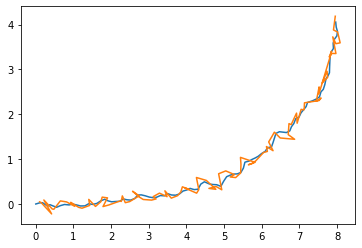

In [249]:
import matplotlib.pyplot as plt

plt.plot(Ss_f[...,0],Ss_f[...,1])
plt.plot(observations[...,0],observations[...,1])
#plt.plot(Ss_s[1:21,0])
#plt.plot(xs,ys)

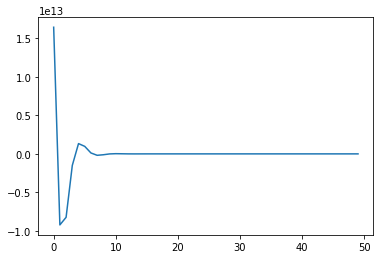

In [240]:
#plt.plot(Ss_f[...,-1])
plt.plot(Ss_s[50:,-1])

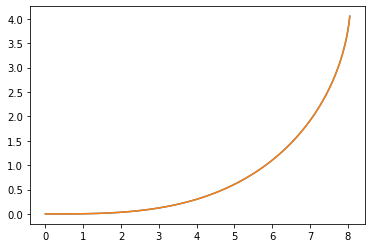

In [212]:
plt.plot(Ss_f[...,0],Ss_f[...,1])
#plt.plot(Ss_s[...,0],Ss_s[...,1])
plt.plot(xs,ys)

In [213]:

#plt.plot(observations[:20])

In [13]:
#_Ss_p = torch.cat(Ss_p[1:],dim=0)
plt.plot(_Ss_p[1:20,0])
plt.plot(_Ss_f[1:20,0])
plt.plot(_Ss_a[1:20])
plt.plot(observations[:19])

NameError: name '_Ss_p' is not defined

In [ ]:
# Ss_p = []
# Ss_f = []
# Ps_p = []
# Ps_f = []
# p = P0
# s = s0
# for t in range(100-1):
#     s,p = kf._prediction(s.view(2,1),c0.view(1,1),dt,p)
#     Ss_p.append(s.data.clone())
#     Ps_p.append(p.data.clone())
    
#     s,p = kf._filtering(s.view(2,1),c0.view(1,1),dt,p,states[t+1,0].view(1,1))
#     Ss_f.append(s.data.clone())
#     Ps_f.append(p.data.clone())
    
# len(Ss_p),len(Ss_f),len(Ps_p),len(Ps_f)


In [ ]:
Ss_p[1].size(),Ss_p[2].size(),Ss_f[0].size(),Ss_f[1].size()

In [ ]:
s = Ss_f[-1]
p = Ps_f[-1]
Ss_s = [Ss_f[-1]]
Ps_s = [Ps_f[-1]]

for _t in range(99):
    t = 99 - (_t )

    

    s_p = Ss_p[t]
    s_f = Ss_f[t-1]
    P_p = Ps_p[t]
    P_f = Ps_f[t-1]
    s,p = kfc._smoothing(s_p,s_f,s,c0.view(1,1),P_p,P_f,p,dt)
    Ss_s.append(s.data.clone())


    Ps_s.append(p.data.clone())



In [ ]:
#_Ss_f = torch.cat([s.view(1,-1) for s in Ss_f],dim=0)


In [ ]:
plt.plot(_Ss_f[:20,0])
plt.plot(_Ss_s[:20,0]),len(_Ss_f),len(_Ss_s)

In [ ]:
_Ss_s = torch.stack(Ss_s,dim=0).view(-1,2).data.numpy()[::-1].copy()
_Ss_f = torch.stack(Ss_f,dim=0)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(_Ss_s[:,0][:10])
plt.plot(_Ss_f[:,0][:10])
plt.plot(states[:,0][1:11])

In [ ]:
len(_Ss_s)